# Fraud detection

In [46]:
%pylab inline
import numpy
import pandas

import tensorflow as tf
import keras as K
import datetime as dt
import seaborn as sns
import matplotlib.gridspec as gridspec


from sklearn import preprocessing
from sklearn import metrics

from sklearn.utils import check_random_state
from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from tensorflow.python.client import device_lib
from keras.backend.tensorflow_backend import set_session

import warnings
warnings.filterwarnings("ignore")

sns.set_style("ticks", {"axes.grid": False, 'xtick.major.size': 5.0,
 'xtick.minor.size': 3.0, 'ytick.major.size': 5.0,'ytick.minor.size': 3.0})
# seaborn.set_context('notebook')
rc = {'legend.fontsize':'medium',
      'axes.labelsize': 'medium',
      'axes.titlesize': 'medium',
      'xtick.labelsize':'medium',
      'ytick.labelsize':'medium'}
sns.set(context='notebook', style='ticks', rc=rc, font='Arial', font_scale=1.3)
colours = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", '#840000']

# Tensorflow Memory management
# proto = device_lib.list_local_devices()
# device_name = '/cpu:0' if '/gpu:0' not in [x.name for x in proto  if x.device_type == 'GPU'] else '/gpu:0'
# tf.device(device_name)

config = tf.ConfigProto(log_device_placement=False, allow_soft_placement=True)
config.gpu_options.allow_growth = True
config.gpu_options.allocator_type = 'BFC'

sess = tf.Session(config=config)
set_session(sess)

rnd = check_random_state(12563)


Populating the interactive namespace from numpy and matplotlib


## Load data

This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
 
It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. 

Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 

Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependent cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.


In [2]:
dataset = pandas.read_csv('data/Dataset.csv')
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
dataset['Date'] = dataset['Time'].apply(lambda x: dt.datetime.fromtimestamp(x).strftime("%d %H:%M:%S"))
dataset = dataset.set_index("Date")
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Date,,,,,,,,,,,,,,,,,,,,,
01 02:00:00,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
01 02:00:00,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
01 02:00:01,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
01 02:00:01,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
01 02:00:02,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
dataset.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Date,,,,,,,,,,,,,,,,,,,,,
03 01:59:46,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
03 01:59:47,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
03 01:59:48,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
03 01:59:48,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
03 01:59:52,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [5]:
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


The dataset contains 284 807 sample and 30 features. The data was collected over a perod of 172 792 seconds (3 days 01:59:52). The data has 0.1727 % fraudulent co

In [6]:
# from MulticoreTSNE import MulticoreTSNE as TSNE
# X_tsne = TSNE(learning_rate=100, n_jobs=8).fit_transform(dataset[['V{}'.format(i) for i in range(1, 29)]].values)

Test if there any missing values in the dataset. The dataset has no missing values.

In [7]:
dataset.isnull().values.any()

False

## Fraud and normal transaction statistics

In [48]:
Y = dataset['Class']
X = dataset[['V{0}'.format(i) for i in range(1, 29)] + ['Time', 'Amount']]
A = dataset['Amount']

In [49]:
print("Fraud statistics")
print(dataset[dataset.Class==1][['Amount', 'Class', 'Time']].describe())

Fraud statistics
            Amount  Class           Time
count   492.000000  492.0     492.000000
mean    122.211321    1.0   80746.806911
std     256.683288    0.0   47835.365138
min       0.000000    1.0     406.000000
25%       1.000000    1.0   41241.500000
50%       9.250000    1.0   75568.500000
75%     105.890000    1.0  128483.000000
max    2125.870000    1.0  170348.000000


In [50]:
print("Normal Transaction statistics")
print(dataset[dataset.Class==0][['Amount', 'Class', 'Time']].describe())

Normal Transaction statistics
              Amount     Class           Time
count  284315.000000  284315.0  284315.000000
mean       88.291022       0.0   94838.202258
std       250.105092       0.0   47484.015786
min         0.000000       0.0       0.000000
25%         5.650000       0.0   54230.000000
50%        22.000000       0.0   84711.000000
75%        77.050000       0.0  139333.000000
max     25691.160000       0.0  172792.000000


## Feature analysis and selection

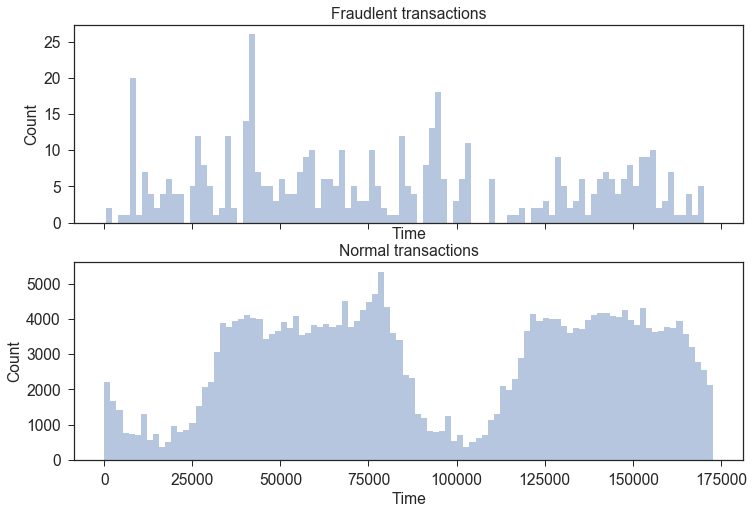

In [51]:
f, ax = subplots(2, 1, sharex=True, figsize=(12,8))
_ = sns.distplot(dataset.Time[dataset.Class == 1], bins=100, ax=ax[0], kde=False, norm_hist=False)
_ = ax[0].set_title('Fraudlent transactions')
_ = ax[0].set_ylabel('Count')

_ = sns.distplot(dataset.Time[dataset.Class == 0], bins=100, ax=ax[1], kde=False, norm_hist=False)
_ = ax[1].set_title('Normal transactions')
_ = ax[1].set_ylabel('Count')

The class `Time` feature histogram is pretty similar across both types of transactions. The  fraudulent transactions are sparse and uniformly distributed, while normal transactions have a cyclical distribution, which coincide with midnight hours. Fraud might be detectable during `off-peak` hours.

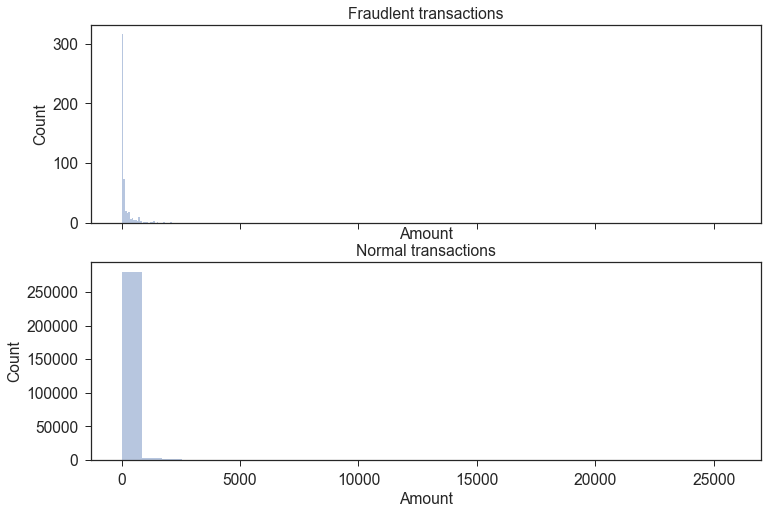

In [52]:
f, ax = subplots(2, 1, sharex=True, figsize=(12,8))
_ = sns.distplot(dataset.Amount[dataset.Class == 1], bins=30, ax=ax[0], kde=False, norm_hist=False)
_ = ax[0].set_title('Fraudlent transactions')
_ = ax[0].set_ylabel('Count')

_ = sns.distplot(dataset.Amount[dataset.Class == 0], bins=30, ax=ax[1], kde=False, norm_hist=False)
_ = ax[1].set_title('Normal transactions')
_ = ax[1].set_ylabel('Count')

Most transactions have small amouts with large amouts as outliers. To deal with outliers we use [`Winsorisation`](https://en.wikipedia.org/wiki/Winsorizing) clipping the data below the `1st` percentile and the data above the `99th` percentile.

In [53]:
from scipy.stats import mstats
X['Amount_win'] = mstats.winsorize(dataset.Amount.values, limits=[0.01, 0.01])

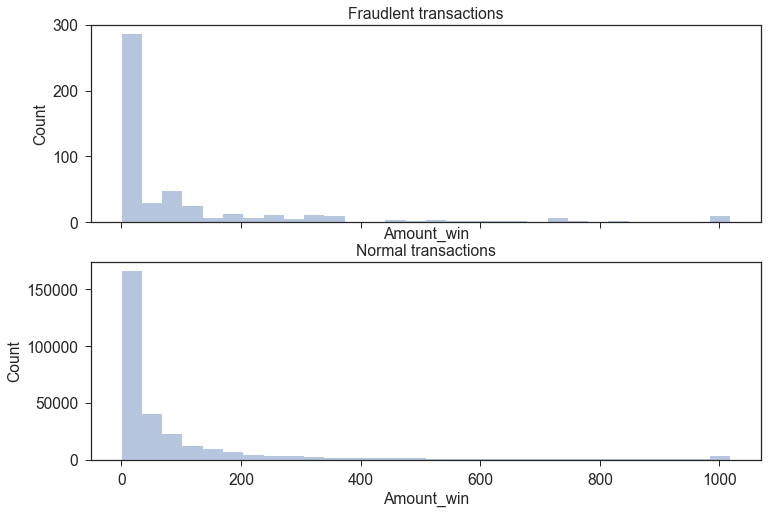

In [54]:
f, ax = subplots(2, 1, sharex=True, figsize=(12,8))
_ = sns.distplot(X.Amount_win[Y == 1], bins=30, ax=ax[0], kde=False, norm_hist=False)
_ = ax[0].set_title('Fraudlent transactions')
_ = ax[0].set_ylabel('Count')

_ = sns.distplot(X.Amount_win[Y == 0], bins=30, ax=ax[1], kde=False, norm_hist=False)
_ = ax[1].set_title('Normal transactions')
_ = ax[1].set_ylabel('Count')

`Winsorization` clips the `Amount` feature between 0 and 100.

In [55]:
def plot_strip(x, y, hue):    
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['Normal', 'Fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, labels, bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

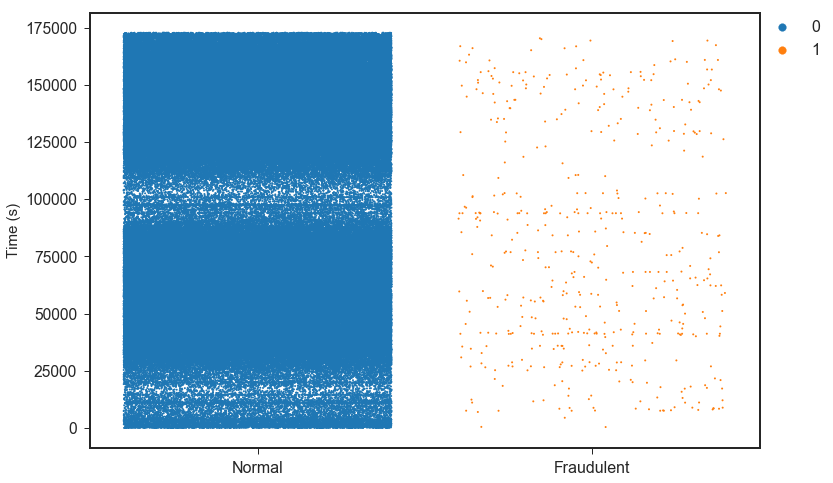

In [56]:
figure(figsize = (12, 8))
ax = plot_strip(Y.values, X.Time.values, Y.values)
_ = ax.set_ylabel('Time (s)')
_ = ax.yaxis.label.set_fontsize(15)

The plot above fraudulent and normal transactions different `fingerprints` when their dispersion is viewed over time. Fradulent transactions are sparse and uniformly distributed over time, when compared to normal transactions.

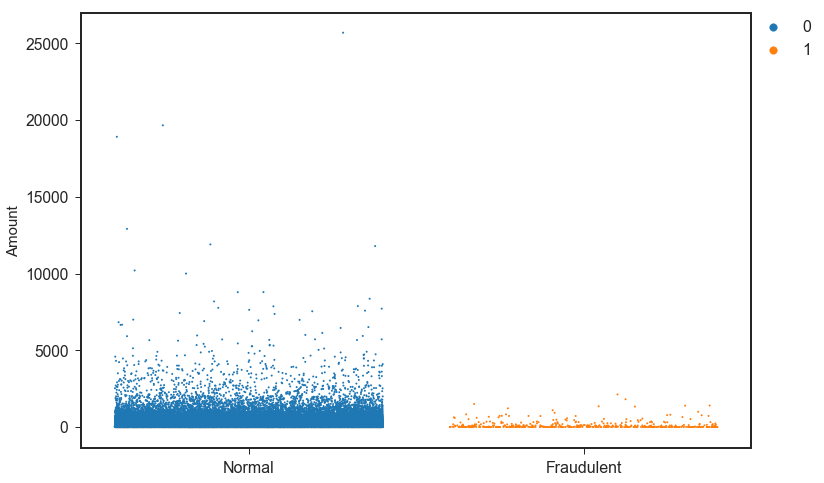

In [57]:
figure(figsize = (12, 8))
ax = plot_strip(Y.values, X.Amount.values, Y.values)
_ = ax.set_ylabel('Amount')
_ = ax.yaxis.label.set_fontsize(15)

The plot above below shows the `Amount` dispersion per-class shown in a previous amount histograms.

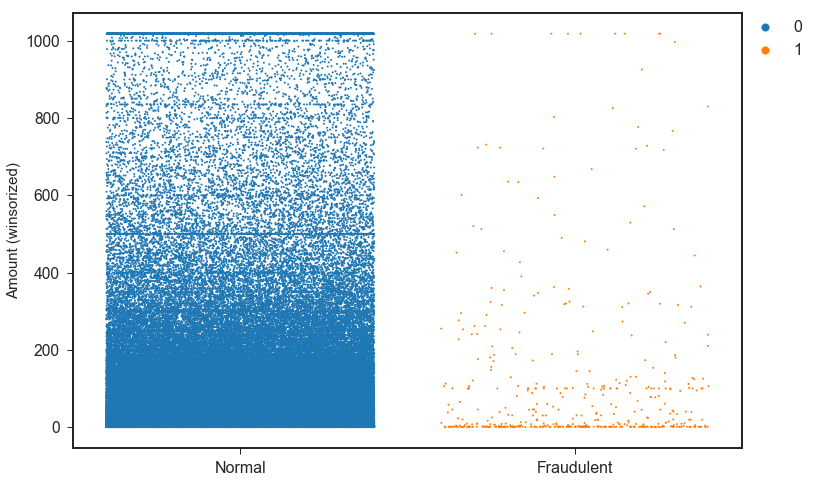

In [58]:
figure(figsize = (12, 8))
ax = plot_strip(Y.values, X.Amount_win.values, Y.values)
_ = ax.set_ylabel('Amount (winsorized)')
_ = ax.yaxis.label.set_fontsize(15)

`Winsorization` reduces the outlies for a more  uniform amount distribution.

### V{1-28} feature selection

The figure below examins how the distributions of each `V` parameter can be separated to classify fraudulent and normal transactions. Examining the figures shows `V1, V6, V7, V8, V13, V15, V23, V27 and V28` to be overlaped.  

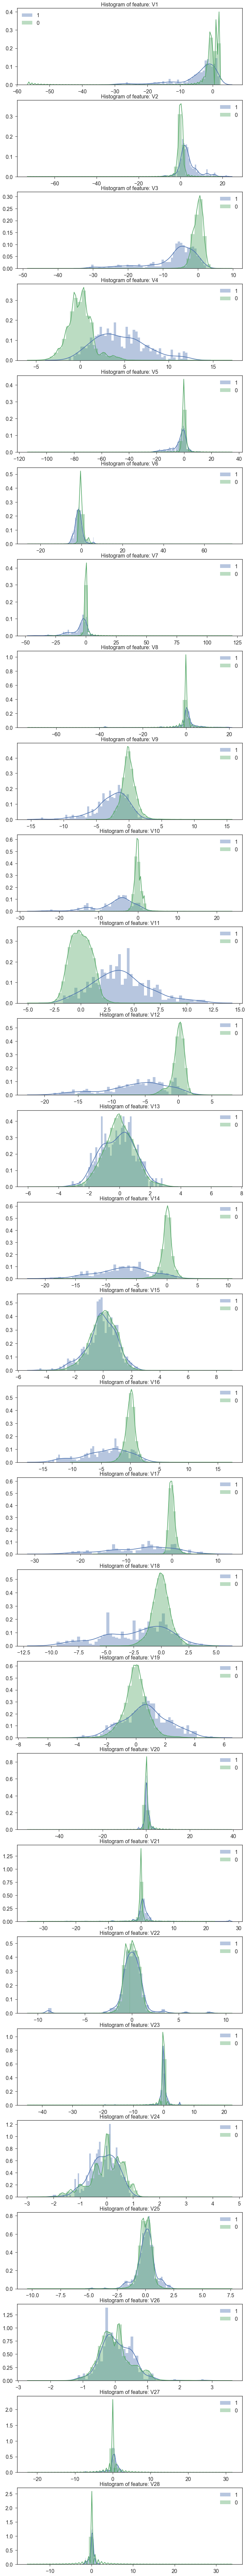

In [60]:
plt.figure(figsize=(12,28*5))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(['V{0}'.format(i) for i in range(1, 29)]):
    ax = plt.subplot(gs[i])
    sns.distplot(X[cn][Y == 1], bins=50, label='1')
    sns.distplot(X[cn][Y == 0], bins=50, label='0')
    ax.legend()
    ax.set_xlabel('')
    ax.set_title('Histogram of feature: ' + str(cn))

show()

In [67]:
from sklearn import metrics
vals = []
for i, cn in enumerate(['V{0}'.format(i) for i in range(1, 29)]):
    bins = np.arange(np.floor((X[cn].values.min())),np.ceil((X[cn].values.max())))
    f, _ = numpy.histogram(X[cn][Y == 1].values, bins=bins, density=1)
    n, _ = numpy.histogram(X[cn][Y == 0].values, bins=bins, density=1)
    # print(cn, '\t--', metrics.mutual_info_score(f, n))
    vals.append((cn, metrics.mutual_info_score(f, n)))

vals_sorted = sorted(vals, key= lambda x: x[1], reverse=True)
vals_sorted

[('V11', 2.557793860107733),
 ('V4', 2.4088758440625395),
 ('V18', 2.338371704803573),
 ('V12', 2.321830237174621),
 ('V14', 2.3195933330733833),
 ('V17', 2.2826375007462634),
 ('V19', 2.1383972463477248),
 ('V1', 2.054656698969742),
 ('V15', 1.9459347757561138),
 ('V26', 1.7917594692280547),
 ('V16', 1.771609838927197),
 ('V13', 1.7379834485870502),
 ('V22', 1.7250947159584382),
 ('V3', 1.6666163489895407),
 ('V9', 1.5635916465579482),
 ('V24', 1.5498260458782016),
 ('V25', 1.534141463948367),
 ('V10', 1.499029781616994),
 ('V8', 1.2458963073608578),
 ('V21', 1.1801535579930118),
 ('V2', 1.1183088168406077),
 ('V5', 1.0264040769756717),
 ('V27', 0.9682822070097732),
 ('V23', 0.8255042322048215),
 ('V7', 0.8160394663395825),
 ('V6', 0.6868717540985613),
 ('V20', 0.6700471619346992),
 ('V28', 0.3959057666889042)]

In place of manually eliminating features based on visual examination we use `Mutual information` between the class histogram distribution for the features.

In [68]:
X_trim = X.drop([k for k,v in vals_sorted if v < 1], axis=1, inplace=True)
print('Droped features {0}'.format([k for k,v in vals_sorted if v < 1]))

Droped features ['V27', 'V23', 'V7', 'V6', 'V20', 'V28']


In [69]:
X.describe()

,V1,V2,V3,V4,V5,V8,V9,V10,V11,V12,...,V18,V19,V21,V22,V24,V25,V26,Time,Amount,Amount_win
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000,284807.000000
mean,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.177556e-16,-2.406455e-15,2.239751e-15,1.673327e-15,-1.254995e-15,...,9.572133e-16,1.039817e-15,1.656562e-16,-3.444850e-16,4.471968e-15,5.340915e-16,1.687098e-15,94813.859575,88.349619,80.193438
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,...,8.381762e-01,8.140405e-01,7.345240e-01,7.257016e-01,6.056471e-01,5.212781e-01,4.822270e-01,47488.145955,250.120109,159.285854
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,...,-9.498746e+00,-7.213527e+00,-3.483038e+01,-1.093314e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,0.000000,0.000000,0.120000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,...,-4.988498e-01,-4.562989e-01,-2.283949e-01,-5.423504e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,54201.500000,5.600000,5.600000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,...,-3.636312e-03,3.734823e-03,-2.945017e-02,6.781943e-03,4.097606e-02,1.659350e-02,-5.213911e-02,84692.000000,22.000000,22.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,...,5.008067e-01,4.589494e-01,1.863772e-01,5.285536e-01,4.395266e-01,3.507156e-01,2.409522e-01,139320.500000,77.165000,77.165000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,...,5.041069e+00,5.591971e+00,2.720284e+01,1.050309e+01,4.584549e+00,7.519589e+00,3.517346e+00,172792.000000,25691.160000,1018.000000


###  Feature correlection measurement

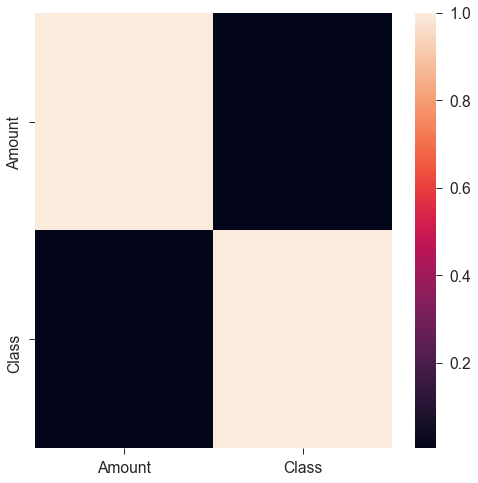

In [24]:
figure(figsize=(8, 8))
ax = sns.heatmap(dataset[['Amount', 'Class']].corr())

There's no correleation between `Amount` and `Class`.

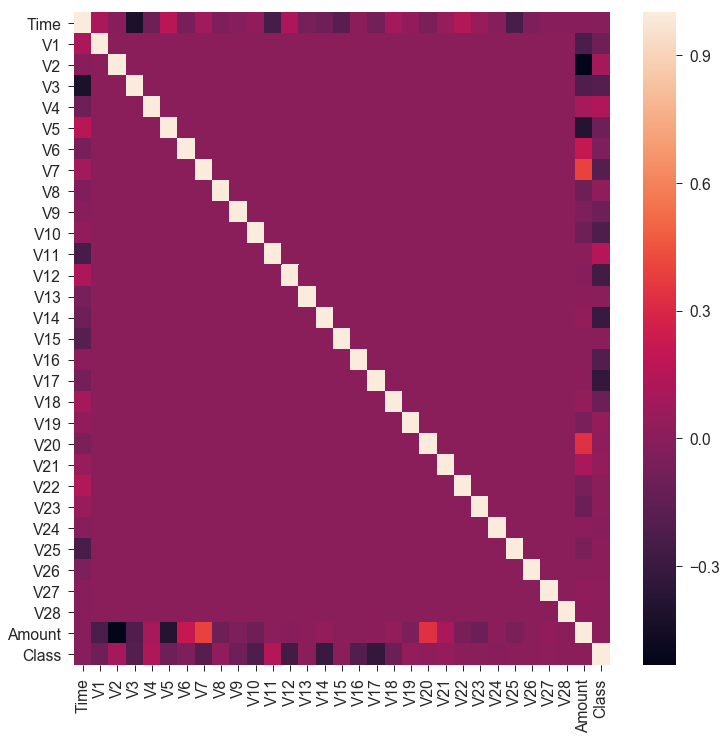

In [25]:
figure(figsize=(12, 12))
ax = sns.heatmap(dataset.corr())

There's no correlation between the `V` features, which is to be expected because PCA principal components are orthogonal. 

### Transactions with zero amounts

In [27]:
x_fraud = X.loc[Y==1]
x_safe = X.loc[Y==0]

print('\nThe fraction of fraudulent transactions with zero amount: {0}/{1}'
      .format(len(x_fraud.loc[x_fraud.Amount == 0]), len(x_fraud)))

print('\nThe fraction of non-fraudulent transactions with zero amount: {0}/{1}'
      .format(len(x_safe.loc[x_safe.Amount == 0]), len(x_safe)))


The fraction of fraudulent transactions with zero amount: 27/492

The fraction of non-fraudulent transactions with zero amount: 1798/284315


Of the 492 fraudulent transactions 27 cases there was no money transfered. How is fraud determined?

In [28]:
print('skew = {0}'.format( len(x_fraud) / float(len(X)) ))

skew = 0.001727485630620034


## Performence measures
Accuracy, precision, recall, ROC curve, AUC, mAP are the metrics of choice when evaluating classification models. This section discusses the merits of each metric for the skewed fraud detection task.

**Accuracy score**

Accuracy is highly dependent on the distribution of positive and negative samples in the evaluation set. Given an evaluation set with 1 000 samples, 990 of which have a negative label, if the model classifies all samples as negative, the accuracy is $99\%$, even though the classifier missed all the positive cases. Accuracy as a performance metric is useful given uniformly distributed categories in the evaluation set. The given dataset is highly skewed, which means that accuracy is not an apt metric to evaluate model performance. However, we do measure the per-category accuracy to evaluate the model's ability to classify both fraudulent and normal transactions.

**AUC score**

The ROC curve is a plot of the TPR against the FPR at different thresholds. The ROC curve is a useful metric in binary classification problems. In multi-class classification, the ROC curve is summarised into a single score (AUC) for each label, in a one-vs-all classification scheme. The AUC score is a single number, which represents the area under the ROC curve. Given a random sample, AUC is the probability that a ranking system assigns a high score to a positive sample. The metric is sensitive to unequal distributions of the classes because of the equal emphasis it places on false positive and negative errors.

**Mean average precision score**

The PR curve is a plot of the precision against recall at different thresholds. The area under the PR curve (AUC-PR) or AP is single value metric that represents the area under the precision-recall curve. The AP score places more emphasis on the positive samples, meaning it is not as sensitive to class imbalances as the AUC-ROC score. The AP score is given by:
$$ m{AP} = \frac{\sum_{k=1}^N\left(P(k)\times \mathrm{rel(k)}\right)}{\sum_{k=1}^N \mathrm{rel(k)}}$$
where $N$ is the total number of samples, $P(k)$ is the precision at cut-off $k$, and $\mathrm {rel(k)} $ is an indicator function, which equals one if the sample ranked $k$ is a true positive and zero otherwise.

In [29]:
from collections import OrderedDict
def category_pred(y_true, y_pred):
    output = OrderedDict()
    for c in numpy.unique(y_true):
        index = y_true == c
        output[c] = OrderedDict([('y_true', y_true[index]), ('y_pred', y_pred[index])])
    return output        

In [30]:
def class_acc(cat_pred):
    output = OrderedDict()
    for c  in cat_pred.keys():
        output[c] = metrics.accuracy_score(cat_pred[c]['y_true'], cat_pred[c]['y_pred'].round())
    return output

In [31]:
def measures(y_true, y_pred, n_classes=2):    
    if y_pred.ndim == 2:
        acc = metrics.accuracy_score(y_true, y_pred.argmax(axis=-1))
        auc = metrics.roc_auc_score(y_true, y_pred[:, 1])
        ap = metrics.average_precision_score(y_true, y_pred[:, 1])
    else:
        acc = metrics.accuracy_score(y_true, y_pred.round())
        auc = metrics.roc_auc_score(y_true, y_pred)
        ap = metrics.average_precision_score(y_true, y_pred)        
    return acc, auc, ap 

In [32]:
y_true = Y.values
y_pred_random = rnd.randint(0, 2, Y.shape[0])
y_pred_fraud = numpy.ones(Y.shape[0])
y_pred_trans = numpy.zeros(Y.shape[0])

print('Random prediction:')
print('---------------------------------------------------------')
print(metrics.classification_report(y_true, y_pred_random))
print('---------------------------------------------------------')
print('Accuracy : {0}\nAUC Score: {1}\nmAP\t : {2}'.format(*measures(y_true, y_pred_random)))
print('---------------------------------------------------------\n\n')

print('All fraud prediction:')
print('---------------------------------------------------------')
print(metrics.classification_report(y_true, y_pred_fraud))
print('---------------------------------------------')
print('Accuracy : {0}\nAUC Score: {1}\nmAP\t : {2}'.format(*measures(y_true, y_pred_fraud)))
print('---------------------------------------------------------\n\n')

print('All Normal transfer prediction:')
print('---------------------------------------------------------')
print(metrics.classification_report(y_true, y_pred_trans))
print('---------------------------------------------------------')
print('Accuracy : {0}\nAUC Score: {1}\nmAP\t : {2}'.format(*measures(y_true, y_pred_trans)))
print('---------------------------------------------------------\n\n')

Random prediction:
---------------------------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.50      0.67    284315
          1       0.00      0.51      0.00       492

avg / total       1.00      0.50      0.66    284807

---------------------------------------------------------
Accuracy : 0.4988571207870593
AUC Score: 0.5055145808303483
mAP	 : 0.0017469232655916772
---------------------------------------------------------


All fraud prediction:
---------------------------------------------------------
             precision    recall  f1-score   support

          0       0.00      0.00      0.00    284315
          1       0.00      1.00      0.00       492

avg / total       0.00      0.00      0.00    284807

---------------------------------------------
Accuracy : 0.001727485630620034
AUC Score: 0.5
mAP	 : 0.001727485630620034
---------------------------------------------------------


All Normal transfer predi

Examining performance metrics against model baselines against *random, all fraud* and *all normal* predictions shows that:
* The mAP metric mesures places an emphasis on the fraudulent cases
* The accuracy metric has a base-line of 99.83 % when from just predicting the megative cases.
* The auc metric baselines to 50 % when you predict miss or randomly guess the classes

# Data modeling

To deal with imbalanced data, one could balance it by discarding the majority class before applying an a learning moldel. This approach however, has the disadvantage of undersampling, which will most likely lead to poor performance on real-world (skewed) test data since almost all the information was discarded. Another approach might be to oversample the minority class, say by the synthetic minority oversampling technique (SMOTE) contained in the [`imblearn`](https://github.com/scikit-learn-contrib/imbalanced-learn) library. *At this moment I dont fully undestand the implications of this kind of sampling, so other approaches were considered*. 

The dataset is not split into training and testing dataset, so we use used 20-fold leave-one-out cross-validation to evaluate the models after performing gridsearch to find the best parameters. Because the dataset is unbalanced, [`Stratified sampling`](https://en.wikipedia.org/wiki/Stratified_sampling) is used to partition the data for cross-validation.

Learning models based on ensembles of decision trees (e.g. [`Gradiet Bosted trees`](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/), [`Random frorest`](https://en.wikipedia.org/wiki/Random_forest)) intrinsically perform well on imbalanced data. These models  can cope with the missing values, unnormalised data and allow for speedup via parallel-processing. Among these algorithms, the extreme gradient-boosted (XGBoost) algorithm used as wells as Random-forest. XGBoost  and Random-Forest allow for weighting the positive class more compared to the negative class --- a setting that also allows to account for the skew in the data.

[`Neural networks`](https://en.wikipedia.org/wiki/Artificial_neural_network), which are very good at mapping when given large data are also examined.

## XGBoost Trees

In [35]:
from xgboost.sklearn import XGBClassifier

xg_best_params = {'learning_rate': 0.5, 'max_depth': 5, 'gamma': 0.0}
weights = (Y == 0).sum() / (Y == 1).sum()
if xg_best_params is None:
    param_grid = {"learning_rate" : [0.9, 0.5, 0.1],
                  "max_depth" : range(3, 12, 2),
                  "gamma":[i/10.0 for i in range(0, 5)]}

    xgb = XGBClassifier(scale_pos_weight=weights, n_jobs=7) 

    clf_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, n_jobs=1, scoring='average_precision', verbose=3,
                           cv=StratifiedKFold(Y, n_folds=2, shuffle=True, random_state=rnd))
    clf_xgb.fit(X, Y)
    print(clf_xgb.best_params_)
    xg_best_params = clf_xgb.best_params_

Fitting 2 folds for each of 100 candidates, totalling 200 fits
[CV] learning_rate=0.9, max_depth=3, gamma=0.0 .......................
[CV]  learning_rate=0.9, max_depth=3, gamma=0.0, score=0.8467113422996572, total=   4.4s
[CV] learning_rate=0.9, max_depth=3, gamma=0.0 .......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV]  learning_rate=0.9, max_depth=3, gamma=0.0, score=0.822091735911508, total=   4.1s
[CV] learning_rate=0.9, max_depth=5, gamma=0.0 .......................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.8s remaining:    0.0s


[CV]  learning_rate=0.9, max_depth=5, gamma=0.0, score=0.8565579223273089, total=   5.1s
[CV] learning_rate=0.9, max_depth=5, gamma=0.0 .......................
[CV]  learning_rate=0.9, max_depth=5, gamma=0.0, score=0.8168291366123133, total=   4.6s
[CV] learning_rate=0.9, max_depth=7, gamma=0.0 .......................
[CV]  learning_rate=0.9, max_depth=7, gamma=0.0, score=0.856968292604465, total=   4.8s
[CV] learning_rate=0.9, max_depth=7, gamma=0.0 .......................
[CV]  learning_rate=0.9, max_depth=7, gamma=0.0, score=0.8113250035620133, total=   4.7s
[CV] learning_rate=0.9, max_depth=9, gamma=0.0 .......................
[CV]  learning_rate=0.9, max_depth=9, gamma=0.0, score=0.8548314661011098, total=   5.0s
[CV] learning_rate=0.9, max_depth=9, gamma=0.0 .......................
[CV]  learning_rate=0.9, max_depth=9, gamma=0.0, score=0.8228100606099641, total=   4.8s
[CV] learning_rate=0.9, max_depth=11, gamma=0.0 ......................
[CV]  learning_rate=0.9, max_depth=11, ga

[CV]  learning_rate=0.5, max_depth=7, gamma=0.1, score=0.8635036345107328, total=   6.7s
[CV] learning_rate=0.5, max_depth=7, gamma=0.1 .......................
[CV]  learning_rate=0.5, max_depth=7, gamma=0.1, score=0.8121111897497172, total=   7.3s
[CV] learning_rate=0.5, max_depth=9, gamma=0.1 .......................
[CV]  learning_rate=0.5, max_depth=9, gamma=0.1, score=0.8561064099802452, total=   7.3s
[CV] learning_rate=0.5, max_depth=9, gamma=0.1 .......................
[CV]  learning_rate=0.5, max_depth=9, gamma=0.1, score=0.8111771543295663, total=   6.8s
[CV] learning_rate=0.5, max_depth=11, gamma=0.1 ......................
[CV]  learning_rate=0.5, max_depth=11, gamma=0.1, score=0.8551525187688535, total=   7.7s
[CV] learning_rate=0.5, max_depth=11, gamma=0.1 ......................
[CV]  learning_rate=0.5, max_depth=11, gamma=0.1, score=0.8177670668243744, total=   6.9s
[CV] learning_rate=0.1, max_depth=3, gamma=0.1 .......................
[CV]  learning_rate=0.1, max_depth=3, 

[CV]  learning_rate=0.1, max_depth=9, gamma=0.2, score=0.849625400195229, total=  10.9s
[CV] learning_rate=0.1, max_depth=9, gamma=0.2 .......................
[CV]  learning_rate=0.1, max_depth=9, gamma=0.2, score=0.7995572650277283, total=  11.0s
[CV] learning_rate=0.1, max_depth=11, gamma=0.2 ......................
[CV]  learning_rate=0.1, max_depth=11, gamma=0.2, score=0.8510110333448123, total=  11.7s
[CV] learning_rate=0.1, max_depth=11, gamma=0.2 ......................
[CV]  learning_rate=0.1, max_depth=11, gamma=0.2, score=0.7993514159609731, total=  12.6s
[CV] learning_rate=0.01, max_depth=3, gamma=0.2 ......................
[CV]  learning_rate=0.01, max_depth=3, gamma=0.2, score=0.6958019425917101, total=   4.5s
[CV] learning_rate=0.01, max_depth=3, gamma=0.2 ......................
[CV]  learning_rate=0.01, max_depth=3, gamma=0.2, score=0.646104088651377, total=   4.4s
[CV] learning_rate=0.01, max_depth=5, gamma=0.2 ......................
[CV]  learning_rate=0.01, max_depth=5,

[CV]  learning_rate=0.01, max_depth=11, gamma=0.3, score=0.7266695400979372, total=  12.0s
[CV] learning_rate=0.01, max_depth=11, gamma=0.3 .....................
[CV]  learning_rate=0.01, max_depth=11, gamma=0.3, score=0.672042308770064, total=  14.2s
[CV] learning_rate=0.9, max_depth=3, gamma=0.4 .......................
[CV]  learning_rate=0.9, max_depth=3, gamma=0.4, score=0.8487642903555485, total=   4.3s
[CV] learning_rate=0.9, max_depth=3, gamma=0.4 .......................
[CV]  learning_rate=0.9, max_depth=3, gamma=0.4, score=0.8199042952589932, total=   4.2s
[CV] learning_rate=0.9, max_depth=5, gamma=0.4 .......................
[CV]  learning_rate=0.9, max_depth=5, gamma=0.4, score=0.8488010230274484, total=   6.5s
[CV] learning_rate=0.9, max_depth=5, gamma=0.4 .......................
[CV]  learning_rate=0.9, max_depth=5, gamma=0.4, score=0.8168758520104801, total=   6.4s
[CV] learning_rate=0.9, max_depth=7, gamma=0.4 .......................
[CV]  learning_rate=0.9, max_depth=7,

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 26.0min finished


{'learning_rate': 0.5, 'max_depth': 5, 'gamma': 0.0}


In [36]:
clf_x = XGBClassifier(scale_pos_weight=weights, n_jobs=-1, **xg_best_params)
cv = StratifiedKFold(Y, n_folds=20, shuffle=True, random_state=rnd)

xg_scores = []
xg_cacc_scores = []
for i, (idx_train, idx_test) in enumerate(cv):
    y_pred = clf_x.fit(X.iloc[idx_train], Y.iloc[idx_train]).predict_proba(X.iloc[idx_test])
    
    cat_pred = category_pred(Y.iloc[idx_test].values, y_pred.argmax(-1))    
    c_acc = class_acc(cat_pred)

    print('Fold {0}\n---------------------------------------------------------'.format(i))
    print(metrics.classification_report(Y.iloc[idx_test], y_pred.argmax(-1)))
    print('---------------------------------------------------------')
    print('Accuracy : {0}\nAUC Score: {1}\nmAP\t : {2}'.format(*measures(Y.iloc[idx_test], y_pred)))
    print('Accuracy : Class 0: {0}\tClass 1: {1}'.format(*c_acc.values()))
    print('---------------------------------------------------------\n\n')
    
    xg_scores.append(measures(Y.iloc[idx_test], y_pred))
    xg_cacc_scores.append(c_acc.values())

Fold 0
---------------------------------------------------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     14216
          1       0.96      0.92      0.94        25

avg / total       1.00      1.00      1.00     14241

---------------------------------------------------------
Accuracy : 0.9997893406361913
AUC Score: 0.9964969048958919
mAP	 : 0.9231862946815145
Accuracy : Class 0: 0.9999296567248172	Class 1: 0.92
---------------------------------------------------------


Fold 1
---------------------------------------------------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     14216
          1       0.95      0.84      0.89        25

avg / total       1.00      1.00      1.00     14241

---------------------------------------------------------
Accuracy : 0.9996489010603188
AUC Score: 0.9654614518851997
mAP	 : 0.8428717211899847
Accuracy : Class 0: 0.9999296567248172	

Fold 16
---------------------------------------------------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     14215
          1       0.91      0.83      0.87        24

avg / total       1.00      1.00      1.00     14239

---------------------------------------------------------
Accuracy : 0.9995786220942482
AUC Score: 0.9971919334036815
mAP	 : 0.9069363454645712
Accuracy : Class 0: 0.9998593035525853	Class 1: 0.8333333333333334
---------------------------------------------------------


Fold 17
---------------------------------------------------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     14215
          1       0.89      0.71      0.79        24

avg / total       1.00      1.00      1.00     14239

---------------------------------------------------------
Accuracy : 0.9993679331413723
AUC Score: 0.9630847696095673
mAP	 : 0.7256371417670863
Accuracy : Class 0: 0.9

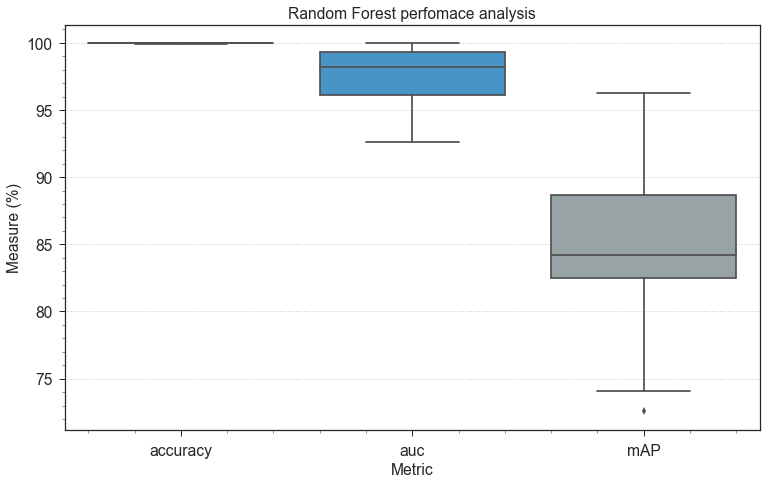

In [71]:
df = pandas.DataFrame(xg_scores, columns=['accuracy', 'auc', 'mAP'])
palette = sns.color_palette(colours)
fig, ax = subplots(figsize=(11, 7)) 
ax.minorticks_on()
ax.set_ylabel('Measure (%)')
ax.set_xlabel('Metric')
ax.grid('on', linestyle='dotted')
ax.set_yticks(numpy.arange(70, 101, 5))
title('Random Forest perfomace analysis')

fg = sns.boxplot(data=df*100, ax=ax, palette=palette)
tight_layout()

In [72]:
df.describe()

,accuracy,auc,mAP
count,20.000000,20.000000,20.000000
mean,0.999589,0.974892,0.855623
std,0.000162,0.023675,0.063842
min,0.999228,0.926280,0.725637
25%,0.999491,0.961390,0.825293
50%,0.999579,0.981986,0.842265
75%,0.999719,0.993311,0.886889
max,0.999860,0.999603,0.962831


Examining the plot above shows accuray to be very high with small variability, which indicates that the model is very apt at detecting normal transactions. The best model classifies 75% of the categories with an mAP that is greater than 83%, and 25% of the categories have an mAP greater than 88%. The average mAP score is $85.56\pm 6.38$

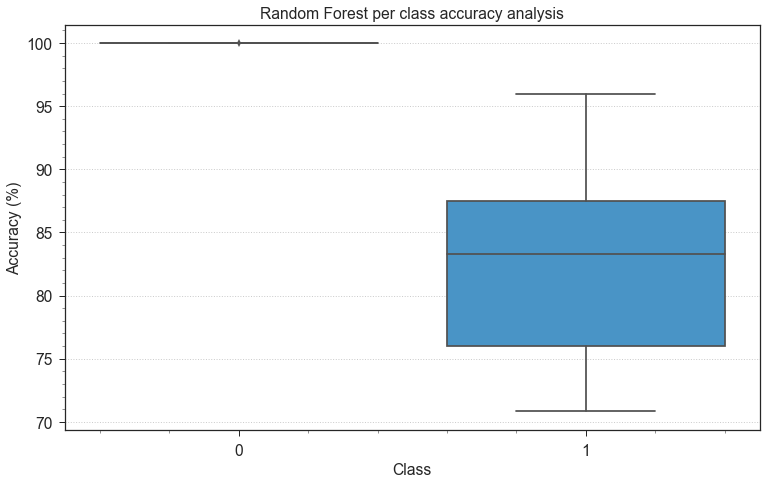

In [73]:
df = pandas.DataFrame(xg_cacc_scores, columns=['0', '1'])
palette = sns.color_palette(colours)
fig, ax = subplots(figsize=(11, 7)) 
ax.minorticks_on()
ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Class')
ax.grid('on', linestyle='dotted')
ax.set_yticks(numpy.arange(70, 101, 5))
title('Random Forest per class accuracy analysis')

fg = sns.boxplot(data=df*100, ax=ax, palette=palette)
tight_layout()

In [74]:
df.describe()

,0,1
count,20.000000,20.000000
mean,0.999884,0.829250
std,0.000080,0.073837
min,0.999719,0.708333
25%,0.999859,0.760000
50%,0.999859,0.833333
75%,0.999930,0.875000
max,1.000000,0.960000


The plot above shows a high accuray for normal transactions with small variability. Fraudulent transactions have a high standard deviation $82.93\pm 7.38$. However, the model generalised well given the small number of fraudulent samples.

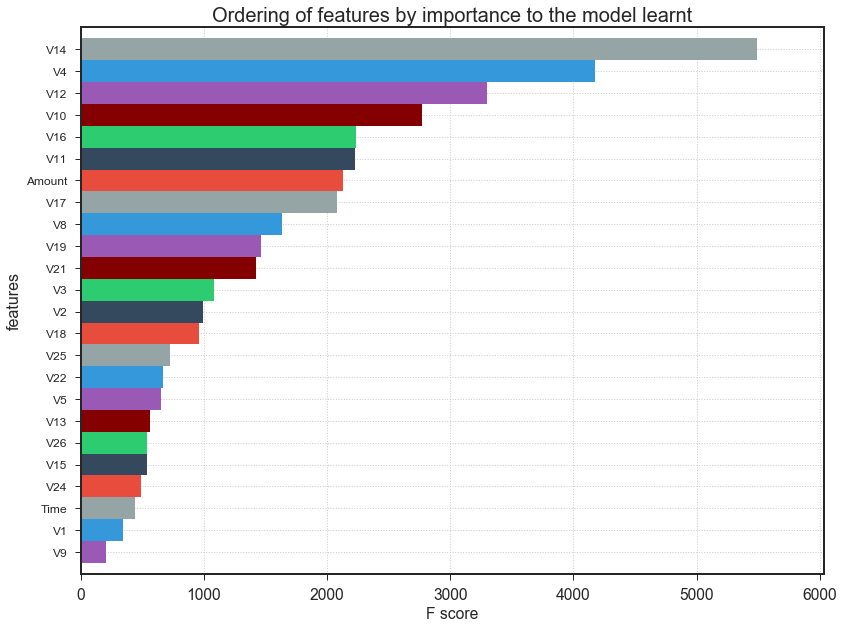

In [83]:
from xgboost import plot_importance, to_graphviz

fig = plt.figure(figsize = (12, 9))
ax = fig.add_subplot(111)

ax = plot_importance(clf_x, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
# ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);
gca().grid('on', linestyle='dotted')
tight_layout()

The figure above shows `V14` and `V4` to be the most relevant features for the model.

## Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {"n_estimators" : range(10, 61, 10),
              "max_depth" : range(3, 31, 5),
              "min_samples_leaf" : range(1, 10, 2)}

rf_best_params = {'n_estimators': 60, 'min_samples_leaf': 1, 'max_depth': 13
if rf_best_params is None:
    rfc = RandomForestClassifier(n_jobs=-1, max_features='sqrt', oob_score = True) 

    clf_rf = GridSearchCV(estimator=rfc, param_grid=param_grid, n_jobs=-1, scoring='average_precision', verbose=3,
                          cv=StratifiedKFold(Y, n_folds=2, shuffle=True, random_state=rnd),)
    clf_rf.fit(X, Y)
    print(clf_rf.best_params_)
    rf_best_params = clf_rf.best_params_

Fitting 2 folds for each of 180 candidates, totalling 360 fits
[CV] n_estimators=10, min_samples_leaf=1, max_depth=3 ................
[CV] n_estimators=10, min_samples_leaf=1, max_depth=3 ................
[CV] n_estimators=20, min_samples_leaf=1, max_depth=3 ................
[CV] n_estimators=20, min_samples_leaf=1, max_depth=3 ................
[CV] n_estimators=30, min_samples_leaf=1, max_depth=3 ................
[CV]  n_estimators=10, min_samples_leaf=1, max_depth=3, score=0.7274702633695783, total=   0.9s
[CV] n_estimators=30, min_samples_leaf=1, max_depth=3 ................
[CV]  n_estimators=10, min_samples_leaf=1, max_depth=3, score=0.7666286094485568, total=   1.4s
[CV] n_estimators=40, min_samples_leaf=1, max_depth=3 ................
[CV] n_estimators=40, min_samples_leaf=1, max_depth=3 ................
[CV] n_estimators=50, min_samples_leaf=1, max_depth=3 ................
[CV]  n_estimators=20, min_samples_leaf=1, max_depth=3, score=0.7628765747067131, total=   2.8s
[CV] n_est

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   13.2s


[CV] n_estimators=30, min_samples_leaf=3, max_depth=3 ................
[CV]  n_estimators=10, min_samples_leaf=3, max_depth=3, score=0.7807845995469034, total=   3.5s
[CV]  n_estimators=40, min_samples_leaf=1, max_depth=3, score=0.7856245020231405, total=   9.8s
[CV] n_estimators=30, min_samples_leaf=3, max_depth=3 ................
[CV] n_estimators=40, min_samples_leaf=3, max_depth=3 ................
[CV] n_estimators=40, min_samples_leaf=3, max_depth=3 ................
[CV]  n_estimators=50, min_samples_leaf=1, max_depth=3, score=0.7704373115839525, total=  12.5s
[CV]  n_estimators=20, min_samples_leaf=3, max_depth=3, score=0.771528566366311, total=   5.7s
[CV]  n_estimators=20, min_samples_leaf=3, max_depth=3, score=0.7823637864578664, total=   4.8s
[CV] n_estimators=50, min_samples_leaf=3, max_depth=3 ................
[CV]  n_estimators=50, min_samples_leaf=1, max_depth=3, score=0.7868690629497649, total=  12.0s
[CV] n_estimators=50, min_samples_leaf=3, max_depth=3 ................

[CV] n_estimators=40, min_samples_leaf=1, max_depth=8 ................
[CV]  n_estimators=10, min_samples_leaf=1, max_depth=8, score=0.8097538364919301, total=   6.8s
[CV] n_estimators=40, min_samples_leaf=1, max_depth=8 ................
[CV]  n_estimators=50, min_samples_leaf=9, max_depth=3, score=0.7641338069086916, total=  13.6s
[CV]  n_estimators=50, min_samples_leaf=9, max_depth=3, score=0.7791696947791479, total=  13.3s
[CV] n_estimators=50, min_samples_leaf=1, max_depth=8 ................
[CV] n_estimators=50, min_samples_leaf=1, max_depth=8 ................
[CV] n_estimators=60, min_samples_leaf=1, max_depth=8 ................
[CV]  n_estimators=60, min_samples_leaf=9, max_depth=3, score=0.7796878838853756, total=  16.0s
[CV]  n_estimators=60, min_samples_leaf=9, max_depth=3, score=0.7820847743847451, total=  15.8s
[CV]  n_estimators=20, min_samples_leaf=1, max_depth=8, score=0.8333202266134179, total=  11.9s
[CV] n_estimators=60, min_samples_leaf=1, max_depth=8 ...............

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  3.1min


[CV] n_estimators=30, min_samples_leaf=9, max_depth=8 ................
[CV] n_estimators=40, min_samples_leaf=9, max_depth=8 ................
[CV] n_estimators=40, min_samples_leaf=9, max_depth=8 ................
[CV]  n_estimators=40, min_samples_leaf=7, max_depth=8, score=0.8301178202240825, total=  32.1s
[CV] n_estimators=50, min_samples_leaf=9, max_depth=8 ................
[CV]  n_estimators=40, min_samples_leaf=7, max_depth=8, score=0.8130479385634756, total=  31.7s
[CV] n_estimators=50, min_samples_leaf=9, max_depth=8 ................
[CV]  n_estimators=20, min_samples_leaf=9, max_depth=8, score=0.8319069506373932, total=  17.0s
[CV] n_estimators=60, min_samples_leaf=9, max_depth=8 ................
[CV]  n_estimators=20, min_samples_leaf=9, max_depth=8, score=0.8029214455194392, total=  16.7s
[CV] n_estimators=60, min_samples_leaf=9, max_depth=8 ................
[CV]  n_estimators=50, min_samples_leaf=7, max_depth=8, score=0.8312630646528755, total=  39.9s
[CV] n_estimators=10, m

[CV]  n_estimators=40, min_samples_leaf=5, max_depth=13, score=0.8353014245187617, total=  50.6s
[CV]  n_estimators=40, min_samples_leaf=5, max_depth=13, score=0.8152890469407736, total=  48.9s
[CV] n_estimators=50, min_samples_leaf=7, max_depth=13 ...............
[CV] n_estimators=50, min_samples_leaf=7, max_depth=13 ...............
[CV]  n_estimators=20, min_samples_leaf=7, max_depth=13, score=0.8379593669041968, total=  26.9s
[CV]  n_estimators=50, min_samples_leaf=5, max_depth=13, score=0.8345465852244499, total= 1.0min
[CV] n_estimators=60, min_samples_leaf=7, max_depth=13 ...............
[CV]  n_estimators=20, min_samples_leaf=7, max_depth=13, score=0.8078182261176013, total=  27.0s
[CV]  n_estimators=50, min_samples_leaf=5, max_depth=13, score=0.8159857801000715, total=  58.3s
[CV] n_estimators=60, min_samples_leaf=7, max_depth=13 ...............
[CV] n_estimators=10, min_samples_leaf=9, max_depth=13 ...............
[CV] n_estimators=10, min_samples_leaf=9, max_depth=13 ........

[CV] n_estimators=50, min_samples_leaf=5, max_depth=18 ...............
[CV] n_estimators=50, min_samples_leaf=5, max_depth=18 ...............
[CV]  n_estimators=50, min_samples_leaf=3, max_depth=18, score=0.841303944123191, total= 1.1min
[CV]  n_estimators=20, min_samples_leaf=5, max_depth=18, score=0.8327109397952644, total=  31.2s
[CV]  n_estimators=50, min_samples_leaf=3, max_depth=18, score=0.8256739589818688, total= 1.1min
[CV] n_estimators=60, min_samples_leaf=5, max_depth=18 ...............
[CV] n_estimators=60, min_samples_leaf=5, max_depth=18 ...............
[CV] n_estimators=10, min_samples_leaf=7, max_depth=18 ...............
[CV]  n_estimators=20, min_samples_leaf=5, max_depth=18, score=0.8140164140550987, total=  33.9s
[CV] n_estimators=10, min_samples_leaf=7, max_depth=18 ...............
[CV]  n_estimators=30, min_samples_leaf=5, max_depth=18, score=0.8349428969681826, total=  44.9s
[CV]  n_estimators=30, min_samples_leaf=5, max_depth=18, score=0.8169842370826401, total= 

[CV]  n_estimators=50, min_samples_leaf=1, max_depth=23, score=0.8105891461243266, total= 1.1min
[CV] n_estimators=60, min_samples_leaf=3, max_depth=23 ...............
[CV]  n_estimators=50, min_samples_leaf=1, max_depth=23, score=0.8466495358395313, total= 1.1min
[CV] n_estimators=60, min_samples_leaf=3, max_depth=23 ...............
[CV]  n_estimators=20, min_samples_leaf=3, max_depth=23, score=0.8136058016965337, total=  29.8s
[CV] n_estimators=10, min_samples_leaf=5, max_depth=23 ...............
[CV]  n_estimators=20, min_samples_leaf=3, max_depth=23, score=0.831453556935742, total=  33.6s
[CV] n_estimators=10, min_samples_leaf=5, max_depth=23 ...............
[CV]  n_estimators=30, min_samples_leaf=3, max_depth=23, score=0.8383769699928773, total=  44.7s
[CV]  n_estimators=30, min_samples_leaf=3, max_depth=23, score=0.7973716619396654, total=  42.8s
[CV] n_estimators=20, min_samples_leaf=5, max_depth=23 ...............
[CV]  n_estimators=60, min_samples_leaf=1, max_depth=23, score=0

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 13.7min


[CV]  n_estimators=20, min_samples_leaf=5, max_depth=23, score=0.8223172308292255, total=  29.5s
[CV] n_estimators=60, min_samples_leaf=5, max_depth=23 ...............
[CV]  n_estimators=20, min_samples_leaf=5, max_depth=23, score=0.8318817139356769, total=  32.5s
[CV] n_estimators=10, min_samples_leaf=7, max_depth=23 ...............
[CV] n_estimators=10, min_samples_leaf=7, max_depth=23 ...............
[CV]  n_estimators=30, min_samples_leaf=5, max_depth=23, score=0.8362137370483692, total=  44.9s
[CV] n_estimators=20, min_samples_leaf=7, max_depth=23 ...............
[CV]  n_estimators=30, min_samples_leaf=5, max_depth=23, score=0.817385650864761, total=  45.4s
[CV] n_estimators=20, min_samples_leaf=7, max_depth=23 ...............
[CV]  n_estimators=10, min_samples_leaf=7, max_depth=23, score=0.8223765067093465, total=  18.9s
[CV] n_estimators=30, min_samples_leaf=7, max_depth=23 ...............
[CV]  n_estimators=10, min_samples_leaf=7, max_depth=23, score=0.8073123599844562, total= 

[CV] n_estimators=10, min_samples_leaf=5, max_depth=28 ...............
[CV]  n_estimators=20, min_samples_leaf=3, max_depth=28, score=0.8066648016644543, total=  36.0s
[CV] n_estimators=10, min_samples_leaf=5, max_depth=28 ...............
[CV]  n_estimators=30, min_samples_leaf=3, max_depth=28, score=0.8120525822567927, total=  43.4s
[CV] n_estimators=20, min_samples_leaf=5, max_depth=28 ...............
[CV]  n_estimators=10, min_samples_leaf=5, max_depth=28, score=0.824630043887814, total=  16.8s
[CV]  n_estimators=30, min_samples_leaf=3, max_depth=28, score=0.8361523727756258, total=  47.4s
[CV] n_estimators=20, min_samples_leaf=5, max_depth=28 ...............
[CV]  n_estimators=60, min_samples_leaf=1, max_depth=28, score=0.8175380402331576, total= 1.2min
[CV] n_estimators=30, min_samples_leaf=5, max_depth=28 ...............
[CV]  n_estimators=10, min_samples_leaf=5, max_depth=28, score=0.8028806177039038, total=  15.7s
[CV] n_estimators=30, min_samples_leaf=5, max_depth=28 .........

[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 20.2min finished


{'n_estimators': 60, 'min_samples_leaf': 1, 'max_depth': 13}


In [44]:
clf_r = RandomForestClassifier(n_jobs=8, max_features='sqrt', oob_score = True, **rf_best_params)

cv = StratifiedKFold(Y, n_folds=20, shuffle=True, random_state=rnd)

rf_scores = []
rf_cacc_scores = []

for i, (idx_train, idx_test) in enumerate(cv):
    y_pred = clf_r.fit(X.iloc[idx_train], Y.iloc[idx_train]).predict_proba(X.iloc[idx_test])
    
    cat_pred = category_pred(Y.iloc[idx_test].values, y_pred.argmax(-1))    
    c_acc = class_acc(cat_pred)

    print('Fold {0}\n---------------------------------------------------------'.format(i))
    print(metrics.classification_report(Y.iloc[idx_test], y_pred.argmax(-1)))
    print('---------------------------------------------------------')
    print('Accuracy : {0}\nAUC Score: {1}\nmAP\t : {2}'.format(*measures(Y.iloc[idx_test], y_pred)))
    print('Accuracy : Class 0: {0}\tClass 1: {1}'.format(*c_acc.values()))
    print('---------------------------------------------------------\n\n')
    
    rf_scores.append(measures(Y.iloc[idx_test], y_pred))
    rf_cacc_scores.append(c_acc.values())

Fold 0
---------------------------------------------------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     14216
          1       0.95      0.80      0.87        25

avg / total       1.00      1.00      1.00     14241

---------------------------------------------------------
Accuracy : 0.9995786812723826
AUC Score: 0.9544625773776027
mAP	 : 0.8209155453637292
Accuracy : Class 0: 0.9999296567248172	Class 1: 0.8
---------------------------------------------------------


Fold 1
---------------------------------------------------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     14216
          1       0.95      0.76      0.84        25

avg / total       1.00      1.00      1.00     14241

---------------------------------------------------------
Accuracy : 0.9995084614844463
AUC Score: 0.9790799099606078
mAP	 : 0.757564076315793
Accuracy : Class 0: 0.9999296567248172	Cl

Fold 16
---------------------------------------------------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     14215
          1       0.89      0.67      0.76        24

avg / total       1.00      1.00      1.00     14239

---------------------------------------------------------
Accuracy : 0.9992977034904137
AUC Score: 0.984444249032712
mAP	 : 0.7878303225492104
Accuracy : Class 0: 0.9998593035525853	Class 1: 0.6666666666666666
---------------------------------------------------------


Fold 17
---------------------------------------------------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     14215
          1       0.90      0.79      0.84        24

avg / total       1.00      1.00      1.00     14239

---------------------------------------------------------
Accuracy : 0.9995083924432896
AUC Score: 0.9225143627623402
mAP	 : 0.7741884644666771
Accuracy : Class 0: 0.99

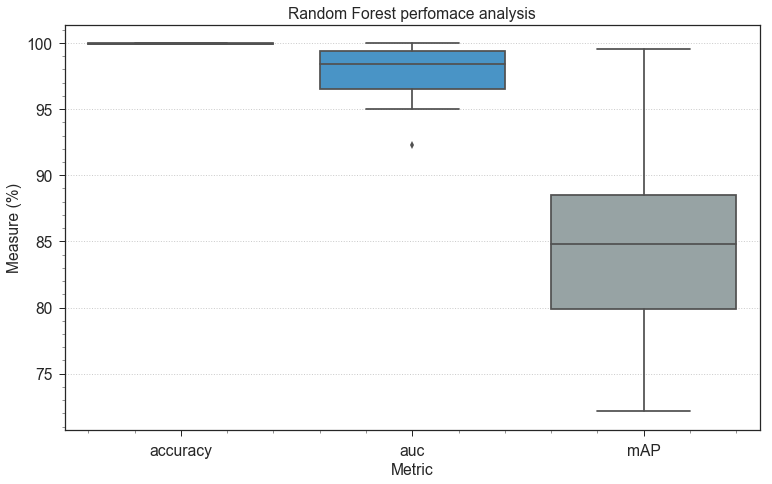

In [76]:
df = pandas.DataFrame(rf_scores, columns=['accuracy', 'auc', 'mAP'])
palette = sns.color_palette(colours)
fig, ax = subplots(figsize=(11, 7)) 
ax.minorticks_on()
ax.set_ylabel('Measure (%)')
ax.set_xlabel('Metric')
ax.grid('on', linestyle='dotted')
ax.set_yticks(numpy.arange(75, 101, 5))
title('Random Forest perfomace analysis')

fg = sns.boxplot(data=df*100, ax=ax, palette=palette)
tight_layout()

In [77]:
df.describe()

,accuracy,auc,mAP
count,20.000000,20.000000,20.000000
mean,0.999579,0.977724,0.848933
std,0.000131,0.020181,0.068133
min,0.999298,0.922514,0.721516
25%,0.999508,0.965260,0.798558
50%,0.999579,0.984130,0.848209
75%,0.999666,0.993631,0.885429
max,0.999789,0.999992,0.995437


The Random-Forest model classifies 75% of the categories with an mAP that is greater than 80% (83% for XGBoost), and 25% of the categories have an mAP greater than 88% (same as XGBoost). The Random-Forest model achieve an mAP score of $84.89\pm 6..81$ compared to XGBoost's $85.56\pm 6.38$. So XGBoost slightly outperforms Random-Forest

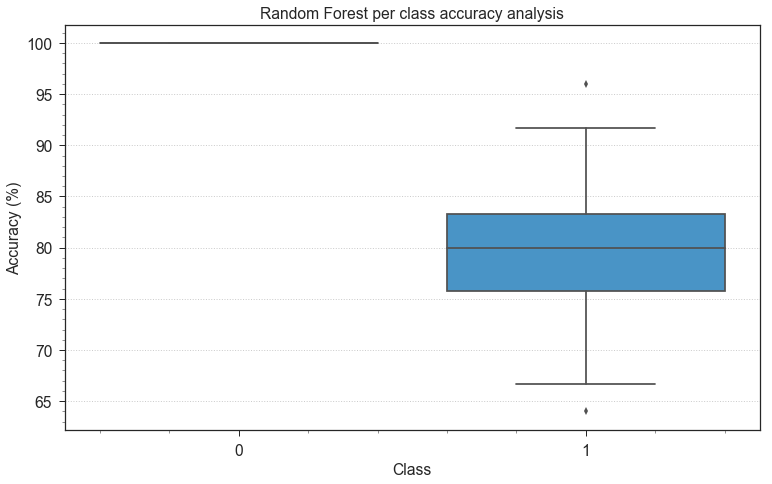

In [78]:
df = pandas.DataFrame(rf_cacc_scores, columns=['0', '1'])
palette = sns.color_palette(colours)
fig, ax = subplots(figsize=(11, 7)) 
ax.minorticks_on()
ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Class')
ax.grid('on', linestyle='dotted')
ax.set_yticks(numpy.arange(0, 101, 5))
title('Random Forest per class accuracy analysis')

fg = sns.boxplot(data=df*100, ax=ax, palette=palette)
tight_layout()

In [79]:
df.describe()

,0,1
count,20.000000,20.000000
mean,0.999940,0.790583
std,0.000052,0.075002
min,0.999859,0.640000
25%,0.999930,0.757500
50%,0.999930,0.800000
75%,1.000000,0.833333
max,1.000000,0.960000


The plot above shows a high accuray for normal transactions with small variability as in the XGBoost case. Fraudulent transactions have a an accuracy of $79.06\pm 7.5$ commpared to XGBoost's  $82.93\pm 7.38$.

### Neural network architecture

In [81]:
from keras import models
from keras import layers
from keras import optimizers
from keras.wrappers import scikit_learn

# Normalize features, beacuse Gradient Decent is sensitive to 
z_norm = preprocessing.StandardScaler()
x = z_norm.fit_transform(X)

# Reset computation graph
K.backend.clear_session()
K.backend.reset_uids()

# create model
def nn_model(n_hidden=64, optimiser='adam', dropout=0):
    model = models.Sequential()
    model.add(layers.BatchNormalization(input_shape=[X.shape[-1]]))
    model.add(layers.Dense(n_hidden, activation='elu', kernel_initializer='he_normal'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(n_hidden, activation='elu', kernel_initializer='he_normal'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal'))

    model.compile(loss='binary_crossentropy', optimizer=optimiser, metrics=['accuracy'])
    return model

nn_best_params = {'batch_size': 128, 'epochs': 10, 'dropout': 0, 'n_hidden': 256, 'optimiser': 'adam'}

if nn_best_params is None:
    model = scikit_learn.KerasClassifier(build_fn=nn_model, verbose=0)
    param_grid = {
        'n_hidden': [64, 128, 256],
        'epochs': [10],
        'optimiser': ['adam', 'rmsprop'],
        'batch_size': [128, 256, 512],
        'dropout': [0, 0.5, 0.7]
    }

    clf_nn = GridSearchCV(estimator=model, param_grid=param_grid, scoring='average_precision', verbose=3,
                          cv=StratifiedKFold(Y, n_folds=2, shuffle=True, random_state=rnd))

    clf_nn.fit(x, Y.values)
    print(clf_nn.best_params_)
    nn_best_params = clf_nn.best_params_

In [82]:
# Reset computation graph
K.backend.clear_session()
K.backend.reset_uids()

model = scikit_learn.KerasClassifier(build_fn=nn_model, verbose=0, **nn_best_params)
cv = StratifiedKFold(Y, n_folds=20, shuffle=True, random_state=rnd)

nn_scores = []
nn_cacc_scores = []
for i, (idx_train, idx_test) in enumerate(cv):
    _ = model.fit(x[idx_train], Y.iloc[idx_train].values)
    y_pred = model.predict_proba(x[idx_test])
    
    cat_pred = category_pred(Y.iloc[idx_test].values, y_pred.argmax(-1))    
    c_acc = class_acc(cat_pred)

    print('Fold {0}\n---------------------------------------------------------'.format(i))
    print(metrics.classification_report(Y.iloc[idx_test], y_pred.argmax(-1)))
    print('---------------------------------------------------------')
    print('Accuracy : {0}\nAUC Score: {1}\nmAP\t : {2}'.format(*measures(Y.iloc[idx_test], y_pred)))
    print('Accuracy : Class 0: {0}\tClass 1: {1}'.format(*c_acc.values()))
    print('---------------------------------------------------------\n\n')
    
    nn_scores.append(measures(Y.iloc[idx_test], y_pred))
    nn_cacc_scores.append(c_acc.values())

Fold 0
---------------------------------------------------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     14216
          1       0.87      0.80      0.83        25

avg / total       1.00      1.00      1.00     14241

---------------------------------------------------------
Accuracy : 0.9994382416965101
AUC Score: 0.9901435002813731
mAP	 : 0.8510710094066318
Accuracy : Class 0: 0.9997889701744513	Class 1: 0.8
---------------------------------------------------------


Fold 1
---------------------------------------------------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     14216
          1       0.96      0.88      0.92        25

avg / total       1.00      1.00      1.00     14241

---------------------------------------------------------
Accuracy : 0.999719120848255
AUC Score: 0.9874141812042768
mAP	 : 0.8837876192300933
Accuracy : Class 0: 0.9999296567248172	Cl

Fold 16
---------------------------------------------------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     14215
          1       0.82      0.58      0.68        24

avg / total       1.00      1.00      1.00     14239

---------------------------------------------------------
Accuracy : 0.9990870145375378
AUC Score: 0.9074129440731622
mAP	 : 0.5972048820699658
Accuracy : Class 0: 0.9997889553288779	Class 1: 0.5833333333333334
---------------------------------------------------------


Fold 17
---------------------------------------------------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     14215
          1       0.94      0.67      0.78        24

avg / total       1.00      1.00      1.00     14239

---------------------------------------------------------
Accuracy : 0.9993679331413723
AUC Score: 0.9635361707116896
mAP	 : 0.7897224751191285
Accuracy : Class 0: 0.9

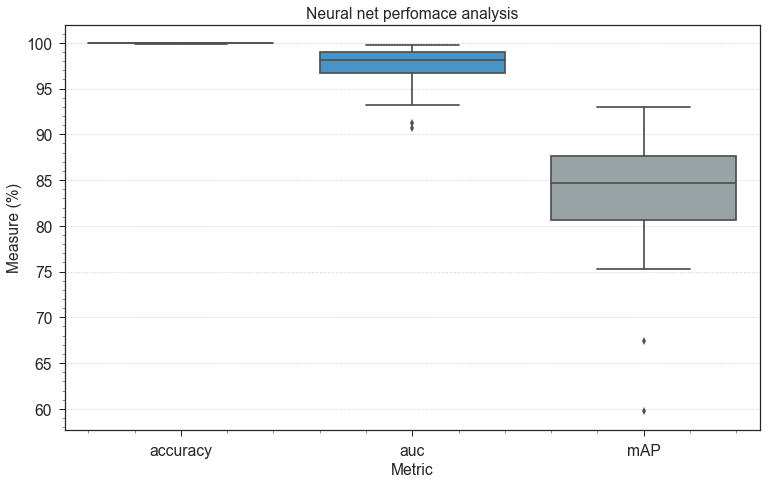

In [86]:
df = pandas.DataFrame(nn_scores, columns=['accuracy', 'auc', 'mAP'])
palette = sns.color_palette(colours)
fig, ax = subplots(figsize=(11, 7)) 
ax.minorticks_on()
ax.set_ylabel('Measure (%)')
ax.set_xlabel('Metric')
ax.grid('on', linestyle='dotted')
ax.set_yticks(numpy.arange(0, 101, 5))
title('Neural net perfomace analysis')

fg = sns.boxplot(data=df*100, ax=ax, palette=palette)
tight_layout()

In [87]:
df.describe()

,accuracy,auc,mAP
count,20.000000,20.000000,20.000000
mean,0.999417,0.971916,0.825573
std,0.000213,0.026429,0.080876
min,0.999087,0.907413,0.597205
25%,0.999280,0.966647,0.806639
50%,0.999368,0.981006,0.846841
75%,0.999579,0.990153,0.875804
max,0.999789,0.997701,0.929698


The Neural Network model classifies 75% of the categories with an mAP that is greater than 80% (83% for XGBoost), and 25% of the categories have an mAP greater than 87.58%. The NN model achieve an mAP score of $82.55\pm 5.97$ compared to XGBoost's $85.56\pm 6.38$. So XGBoost outperforms the NN model.

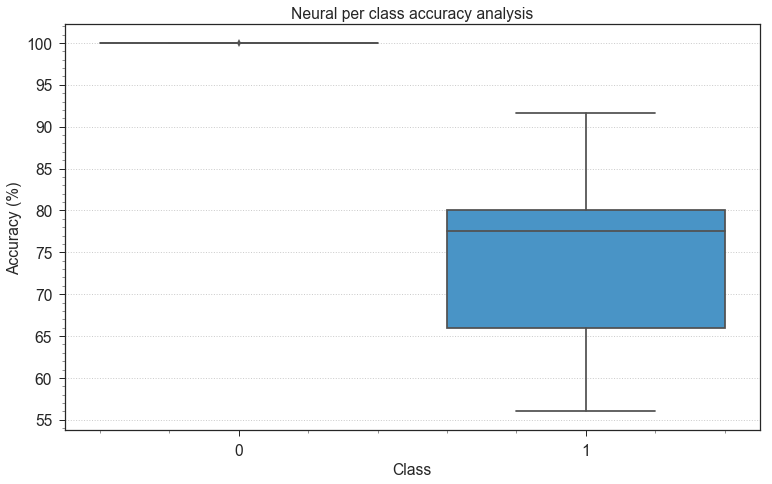

In [90]:
df = pandas.DataFrame(nn_cacc_scores, columns=['0', '1'])
palette = sns.color_palette(colours)
fig, ax = subplots(figsize=(11, 7)) 
ax.minorticks_on()
ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Class')
ax.grid('on', linestyle='dotted')
ax.set_yticks(numpy.arange(0, 101, 5))
title('Neural per class accuracy analysis')

fg = sns.boxplot(data=df*100, ax=ax, palette=palette)
tight_layout()

In [91]:
df.describe()

,0,1
count,20.000000,20.000000
mean,0.999863,0.742083
std,0.000147,0.099534
min,0.999367,0.560000
25%,0.999789,0.660000
50%,0.999930,0.775833
75%,0.999930,0.800000
max,1.000000,0.916667


The plot above shows a high accuray for normal transactions with small variability as in the XGBoost and Rnadom-Trees cases. Fraudulent transactions have a an accuracy of $74.21\pm 9.95$ commpared to XGBoost's  $82.93\pm 7.38$. The neural network model has a higher standard deviation when compared to the other ensamble models.

## Conclusion

XGBoost is the best model evaluated for this task. More features should be engineered which might help with the classification. Try SMOTE to ovasample the fraudulent class and create a balanced dataset. Try a deeper NN and use Random Grid-search instead.

# Deployment

Use the model fitted on the entire training set and set it up such that int monitor transactions made every $n$ seconds depending on the time of day. On week ends use the data collected during the week to retrain a new model and evaluate it agains the old one. Replace models if necessary. 